# Определение возраста покупателей

Цель - построить модель, которая по фотографии определит приблизительный возраст человека. 

### План работы над проектом
1. Провести исследовательский анализ набора фотографий.
2. Подготовить данные к обучению.
3. Обучить нейронную сеть и рассчитайте её качество.

## 1. Исследовательский анализ данных

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [ ]:
labels.shape

(7591, 2)

array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

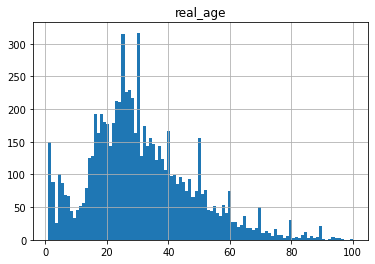

In [ ]:
labels.hist(bins=100)

In [ ]:
print(labels.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000



Похоже на нормальное распределение с перекосом вправо. В датасете присутствуют данные по возрасту от 1 до 100 лет. Основная часть данных  приходится на возраст от 16 до 40 лет, со средним значением 31 год. В возрасте от 75 до 100 лет- единичные значения

На графике видны пики в возрасте 25, 30, 40, 50, 60, 70 лет. Скорее всего, это связано с тем что точный возраст не был известен и его округляли.




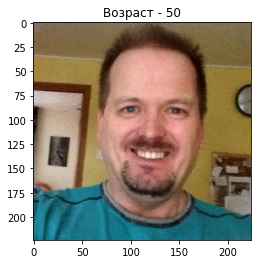

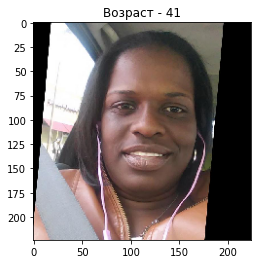

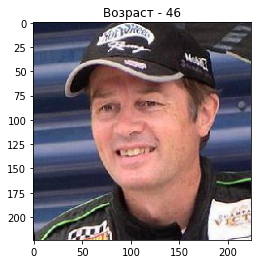

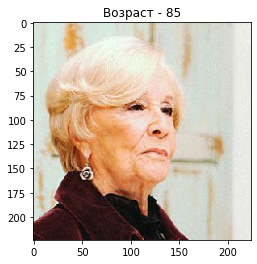

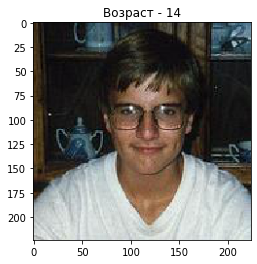

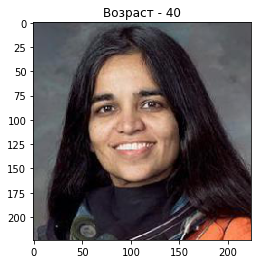

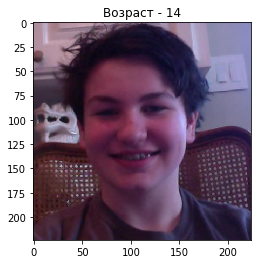

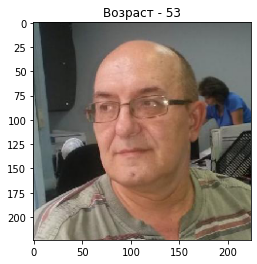

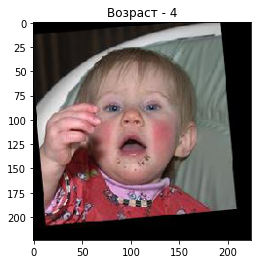

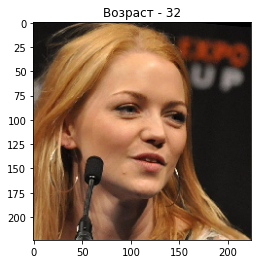

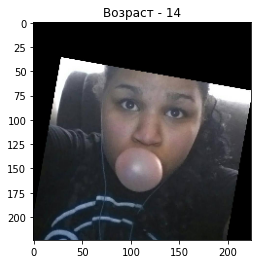

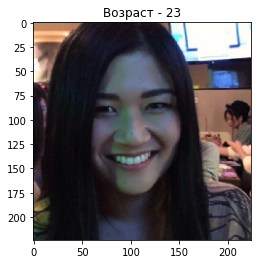

In [ ]:
features, target = train_gen_flow.next()
for i in range(12):
    plt.imshow(features[i])
    plt.title(f'Возраст - {target[i]}')
    plt.show();

В датасете 7591 фотография. Фотграфии сделаны с разным освещением, на разных не однотонных фонах, есть посторонные предметы и темный фон по краям. Модель будет плохо предсказывать возраст пожилых людей.

## 2. Обучение модели

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       horizontal_flip=True, 
                                       rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels, 
                                                       directory=path + 'final_files/', 
                                                       x_col='file_name', 
                                                       y_col='real_age', 
                                                       target_size=(224, 224), 
                                                       batch_size=16, 
                                                       class_mode='raw',
                                                       subset='training', 
                                                       seed=12345)
 
    return train_gen_flow

In [ ]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_gen_flow

In [ ]:
def create_model(input_shape):    
    backbone = ResNet50(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

Train for 356 steps, validate for 119 steps
Epoch 1/10
2022-07-04 14:32:37.907228: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-04 14:32:38.201917: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 48s - loss: 210.5011 - mae: 10.9781 - val_loss: 277.9108 - val_mae: 13.0243
Epoch 2/10
356/356 - 39s - loss: 135.1209 - mae: 8.8684 - val_loss: 257.3448 - val_mae: 12.2158
Epoch 3/10
356/356 - 39s - loss: 111.7868 - mae: 8.0515 - val_loss: 131.8538 - val_mae: 8.9673
Epoch 4/10
356/356 - 38s - loss: 93.9083 - mae: 7.3427 - val_loss: 153.1149 - val_mae: 9.7378
Epoch 5/10
356/356 - 38s - loss: 83.2406 - mae: 6.9779 - val_loss: 167.8621 - val_mae: 9.6509
Epoch 6/10
356/356 - 38s - loss: 68.1901 - mae: 6.3386 - val_loss: 103.9910 - val_mae: 7.6327
Epoch 7/10
356/356 - 39s - loss: 57.1140 - mae: 5.8096 - val_loss: 100.6221 - val_mae: 7.4585
Epoch 8/10
356/356 - 38s - loss: 48.7031 - mae: 5.3736 - val_loss: 185.3979 - val_mae: 11.0218
Epoch 9/10
356/356 - 39s - loss: 43.6006 - mae: 5.0970 - val_loss: 85.9001 - val_mae: 7.1347
Epoch 10/10
356/356 - 38s - loss: 38.7965 - mae: 4.7924 - val_loss: 95.2816 - val_mae: 7.5048

## 3. Анализ обученной модели

Для обучения взяли нейронную сеть с архитектурой ResNet50 и обучили ее на наших данных. Использовали оптимизатор Adam с шагом обучения 0.0005.
Протестировали модель с этими параметрами на 10 эпохах, достигли метрики МАЕ в 7.1347 на 9 эпохе. На 10 эпохе МАЕ на обучающей выборке продолжает уменьшаться, но на тестовых данных увеличивается. Модель можно ограничить 9 эпохами.